In [1]:
import math
import time
import timeit
import re
import string

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('example_password_dataset.csv')

In [3]:
df.head()

,Unnamed: 0,password,count,length,common_password,common_word,too_many_repeats,bad_password,all_lower_case,all_upper_case,all_digits,all_special,upper,lower,digits,symbols
0,0,1980289,13.0,7,False,False,False,False,False,False,True,False,0,0,7,0
1,1,tornadof,13.0,8,False,False,False,False,True,False,False,False,0,8,0,0
2,2,vova87653,13.0,9,False,False,False,False,True,False,False,False,0,4,5,0
3,3,XpKvShrO,13.0,8,False,False,False,False,False,False,False,False,4,4,0,0
4,4,tvjgtl,13.0,6,False,False,False,False,True,False,False,False,0,6,0,0


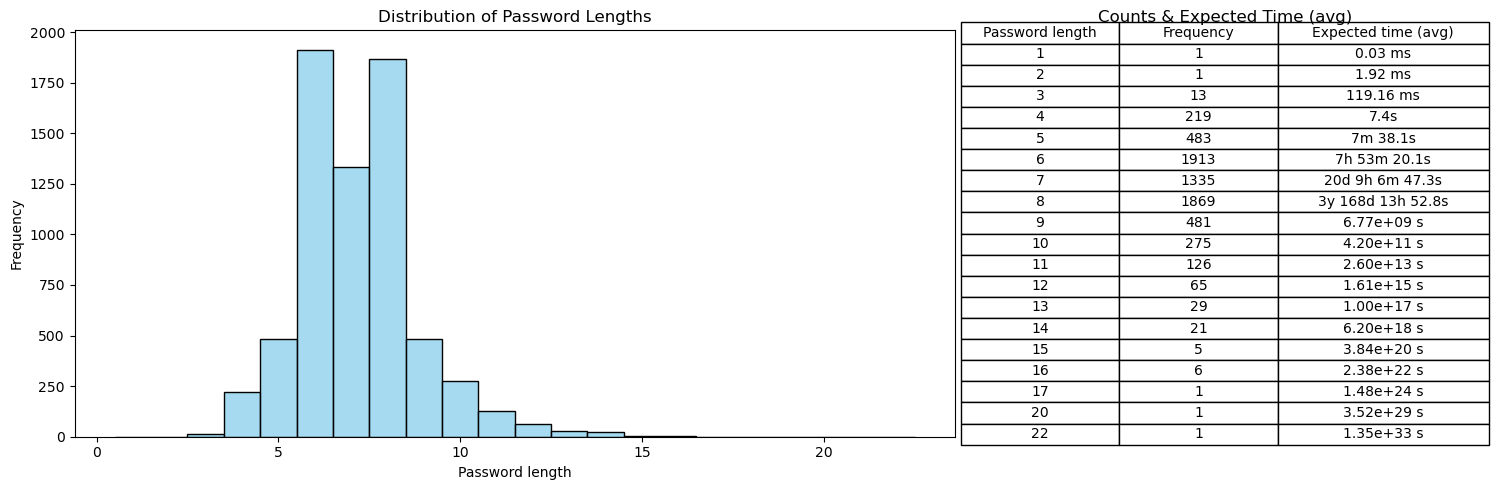

In [4]:
import math
import matplotlib.pyplot as plt
import seaborn as sns

# --- Config ---
GUESS_RATE = 1e6   # abstract guesses per second
ALPHABET_SIZE = 62 # alphanumeric mixed-case + digits
SECONDS_PER_YEAR = 365.2425 * 24 * 3600  # ~31,556,952 s

def human_time(seconds: float) -> str:
    if seconds < 1:
        return f"{seconds*1000:.2f} ms"
    m, s = divmod(seconds, 60)
    h, m = divmod(m, 60)
    d, h = divmod(h, 24)
    y, d = divmod(d, 365)
    parts = []
    if y: parts.append(f"{int(y)}y")
    if d: parts.append(f"{int(d)}d")
    if h: parts.append(f"{int(h)}h")
    if m: parts.append(f"{int(m)}m")
    parts.append(f"{s:.1f}s")
    return " ".join(parts)

def format_mixed(seconds: int | float, year_threshold: float = 99) -> str:
    """Human-readable unless >= year_threshold years, then scientific notation."""
    if seconds >= year_threshold * SECONDS_PER_YEAR:
        val = float(seconds)
        return "∞ s" if math.isinf(val) else f"{val:.2e} s"
    return human_time(float(seconds))

# add a length column
df['length'] = df['password'].astype(str).str.len()

# compute counts by length
counts = df['length'].value_counts().sort_index()
counts_df = counts.reset_index()
counts_df.columns = ["Password length", "Frequency"]

# add expected time (avg), switching format at 99 years
counts_df['Expected time (avg)'] = counts_df['Password length'].apply(
    lambda L: format_mixed((ALPHABET_SIZE**L) / (2 * GUESS_RATE), year_threshold=99)
)

# --- Plot: histogram + table (with wider Expected time column) ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5), gridspec_kw={'width_ratios':[2,1]})

sns.histplot(df['length'], bins=range(df['length'].min(), df['length'].max() + 2),
             discrete=True, ax=ax1, color="skyblue", edgecolor="black")
ax1.set_xlabel("Password length")
ax1.set_ylabel("Frequency")
ax1.set_title("Distribution of Password Lengths")

ax2.axis("off")
col_widths = [0.3,0.3,0.4]
table = ax2.table(cellText=counts_df.values,
                  colLabels=counts_df.columns,
                  cellLoc='center',
                  loc='center',
                  colWidths=col_widths)
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)
ax2.set_title("Counts & Expected Time (avg)")

plt.tight_layout()
plt.show()


In [5]:
target_pattern = df['password'][0]

In [6]:
n = int(target_pattern)
pass_len = len(target_pattern)

def search():
    for i in range(100000000):
        if i == n:
            break  # optional, otherwise it keeps looping

# time how long it takes to run once
elapsed = timeit.timeit(search, number=1)
print(f"Took {elapsed:.6f} seconds to guess the {pass_len} digit password")


Took 0.515852 seconds to guess the 7 digit password


In [7]:
### Time / complexity

# ---------- Helpers ----------
def search_space_size(alpha_size: int, length: int) -> int:
    return alpha_size ** length

def entropy_bits(alpha_size: int, length: int) -> float:
    return length * math.log2(alpha_size)

def human_readable(seconds: float) -> str:
    # readable (ms / s / m / h / d / y)
    if seconds < 1:
        return f"{seconds*1000:.3f} ms"
    mins, sec = divmod(seconds, 60)
    hours, mins = divmod(mins, 60)
    days, hours = divmod(hours, 24)
    years, days = divmod(days, 365)
    parts = []
    if years:
        parts.append(f"{int(years)}y")
    if days:
        parts.append(f"{int(days)}d")
    if hours:
        parts.append(f"{int(hours)}h")
    if mins:
        parts.append(f"{int(mins)}m")
    parts.append(f"{sec:.2f}s")
    return " ".join(parts)

# ---------- Config ----------
guesses_per_sec = 1e6   # abstract attack speed used for conceptual estimates
max_len = 12            # lengths to evaluate (1..max_len)
alphabets = {
    "digits (0-9)": string.digits,                                  # 10
    "digits+lower (0-9,a-z)": string.digits + string.ascii_lowercase, # 36
    "alphanumeric (0-9,a-z,A-Z)": string.digits + string.ascii_letters # 62
}

# ---------- Build numeric DataFrame ----------
rows = []
for alpha_name, alphabet in alphabets.items():
    alpha_size = len(set(alphabet))
    prev_expected = None
    for L in range(1, max_len + 1):
        space = search_space_size(alpha_size, L)
        ent = entropy_bits(alpha_size, L)
        expected_sec = space / (2 * guesses_per_sec)  # average-case (uniform guess)
        worst_sec = space / guesses_per_sec
        pct_inc = None if prev_expected is None else (expected_sec - prev_expected) / prev_expected * 100.0
        rows.append({
            "Alphabet": alpha_name,
            "Alphabet size": alpha_size,
            "Length": L,
            "Search space": space,
            "Entropy (bits)": ent,
            "Expected sec (avg)": expected_sec,
            "Worst sec": worst_sec,
            "Pct increase vs prev length (expected)": pct_inc
        })
        prev_expected = expected_sec

df = pd.DataFrame(rows)

# ---------- Add human-readable/display columns (keeps numeric originals) ----------
df["Search space (fmt)"] = df["Search space"].map(lambda x: f"{int(x):,}")
df["Entropy (bits, fmt)"] = df["Entropy (bits)"].map(lambda v: f"{v:.1f}")
df["Expected (readable)"] = df["Expected sec (avg)"].map(human_readable)
# df["Worst (readable)"] = df["Worst sec"].map(human_readable)
df["Pct increase (fmt)"] = df["Pct increase vs prev length (expected)"].map(
    lambda v: "—" if pd.isna(v) else f"{v:+.2f}%"
)

# reorder columns for presentation
present_cols = [
    "Alphabet", "Alphabet size", "Length",
    "Search space", "Search space (fmt)",
    "Entropy (bits)", "Entropy (bits, fmt)",
    "Expected sec (avg)", "Expected (readable)",
    # "Worst sec", "Worst (readable)",
    "Pct increase vs prev length (expected)", "Pct increase (fmt)"
]
df = df[present_cols]

# ---------- Display nicely in Jupyter (Styler) ----------
# Set display preferences (optional)
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

# Create a Styler for nicer display: format numeric columns, highlight large values
styler = (
    df.style
      .format({
          "Search space": "{:,}",
          "Entropy (bits)": "{:.1f}",
          "Expected sec (avg)": "{:.6e}",
          # "Worst sec": "{:.6e}",
          "Pct increase vs prev length (expected)": lambda v: "—" if pd.isna(v) else f"{v:.2f}%"
      })
      .set_caption(f"Password search estimates — guesses/sec = {int(guesses_per_sec):,}")
      .background_gradient(subset=["Entropy (bits)"], cmap="Greens")
)

# ---------- Export option ----------
# Save full numeric table (useful for reports)
df.to_csv("password_search_estimates_numeric.csv", index=False)
# Save a human-friendly CSV using the formatted columns
df_human = df[["Alphabet", "Length", "Search space (fmt)", "Entropy (bits, fmt)", "Expected (readable)", "Pct increase (fmt)"]]
df_human.to_csv("password_search_estimates_human.csv", index=False)

In [8]:
df_human

,Alphabet,Length,Search space (fmt),"Entropy (bits, fmt)",Expected (readable),Pct increase (fmt)
0,digits (0-9),1,10,3.3,0.005 ms,—
1,digits (0-9),2,100,6.6,0.050 ms,+900.00%
2,digits (0-9),3,"1,000",10.0,0.500 ms,+900.00%
3,digits (0-9),4,"10,000",13.3,5.000 ms,+900.00%
4,digits (0-9),5,"100,000",16.6,50.000 ms,+900.00%
5,digits (0-9),6,"1,000,000",19.9,500.000 ms,+900.00%
6,digits (0-9),7,"10,000,000",23.3,5.00s,+900.00%
7,digits (0-9),8,"100,000,000",26.6,50.00s,+900.00%
8,digits (0-9),9,"1,000,000,000",29.9,8m 20.00s,+900.00%
9,digits (0-9),10,"10,000,000,000",33.2,1h 23m 20.00s,+900.00%


In [9]:
# ---------- Config ----------
GUESS_RATE = 1e6   # abstract guesses per second used for estimates (change as needed)
ENTROPY_THRESHOLDS_BITS = {
    "Very weak": 0,    # up to 28 bits
    "Weak": 28,
    "Moderate": 36,
    "Strong": 60,
    "Very strong": 80
}
# For symbol counting we approximate the symbol alphabet size
SYMBOL_ALPHABET_SIZE = 32

# ---------- Helpers ----------
def estimate_alphabet_size(pw: str) -> int:
    """Estimate alphabet size used by a password based on character classes present."""
    s = set(pw)
    size = 0
    if any(c.islower() for c in s):
        size += 26
    if any(c.isupper() for c in s):
        size += 26
    if any(c.isdigit() for c in s):
        size += 10
    if any((not c.isalnum()) for c in s):
        size += SYMBOL_ALPHABET_SIZE
    # fallback minimal size for non-empty strings
    return max(size, 1)

def entropy_bits_from_alphabet(alpha_size: int, length: int) -> float:
    """Compute entropy bits for given alphabet size and length."""
    if alpha_size <= 1 or length <= 0:
        return 0.0
    return length * math.log2(alpha_size)

def human_readable_time(seconds: float) -> str:
    """Convert seconds to a human readable string (ms / s / m / h / d / y)."""
    if seconds is None or (isinstance(seconds, float) and math.isinf(seconds)):
        return "∞"
    if seconds < 1:
        return f"{seconds*1000:.2f} ms"
    mins, sec = divmod(seconds, 60)
    hours, mins = divmod(mins, 60)
    days, hours = divmod(hours, 24)
    years, days = divmod(days, 365)
    parts = []
    if int(years): parts.append(f"{int(years)}y")
    if int(days): parts.append(f"{int(days)}d")
    if int(hours): parts.append(f"{int(hours)}h")
    if int(mins): parts.append(f"{int(mins)}m")
    parts.append(f"{sec:.1f}s")
    return " ".join(parts)

def classify_complexity(entropy_bits: float) -> str:
    """Map entropy bits to complexity labels using ENTROPY_THRESHOLDS_BITS."""
    # thresholds are lower bounds for the category; evaluate from highest to lowest
    order = ["Very strong", "Strong", "Moderate", "Weak", "Very weak"]
    bounds = ENTROPY_THRESHOLDS_BITS
    for label in order:
        if entropy_bits >= bounds[label]:
            return label
    return "Very weak"

def space_size_from_alphabet(alpha_size: int, length: int):
    try:
        return alpha_size ** length
    except OverflowError:
        return float("inf")

# ---------- Apply to df['password'] ----------
# Defensive: work on a copy
df_audit = df.copy()

if 'password' not in df_audit.columns:
    raise KeyError("DataFrame must contain 'password' column")

# Ensure string type (avoid None issues)
df_audit['password_str'] = df_audit['password'].astype(str)

# Estimate alphabet size per-password
df_audit['est_alphabet_size'] = df_audit['password_str'].map(estimate_alphabet_size)

# Password length
df_audit['pw_length'] = df_audit['password_str'].map(len)

# Entropy (bits) from estimated alphabet size and length
df_audit['entropy_bits_calc'] = df_audit.apply(
    lambda r: entropy_bits_from_alphabet(int(r['est_alphabet_size']), int(r['pw_length'])),
    axis=1
)

# Complexity label
df_audit['complexity'] = df_audit['entropy_bits_calc'].map(classify_complexity)

# Compute search-space (may be very large)
def compute_space(alpha_size, length):
    try:
        return alpha_size ** length
    except OverflowError:
        return float('inf')

df_audit['search_space'] = df_audit.apply(
    lambda r: compute_space(int(r['est_alphabet_size']), int(r['pw_length'])),
    axis=1
)

# Expected and worst-case time to brute-force (uniform model)
# expected: space / (2 * GUESS_RATE)
# worst: space / GUESS_RATE
def expected_seconds_from_space(space, guesses_per_sec=GUESS_RATE):
    if space == float('inf'):
        return float('inf')
    return space / (2.0 * guesses_per_sec)

def worst_seconds_from_space(space, guesses_per_sec=GUESS_RATE):
    if space == float('inf'):
        return float('inf')
    return space / guesses_per_sec

df_audit['expected_seconds_uniform'] = df_audit['search_space'].map(expected_seconds_from_space)
df_audit['worst_seconds_uniform'] = df_audit['search_space'].map(worst_seconds_from_space)

# Add human-readable strings
df_audit['expected_time_readable'] = df_audit['expected_seconds_uniform'].map(human_readable_time)
df_audit['worst_time_readable'] = df_audit['worst_seconds_uniform'].map(human_readable_time)

# Optional: complexity score (same as entropy but rounded)
df_audit['entropy_bits_rounded'] = df_audit['entropy_bits_calc'].map(lambda x: round(x, 1))

# Present and export columns (masking recommended if exporting)
# If you already have a masking function from previous steps, use it; otherwise simple mask:
def mask_password(pw: str, keep_first_last=True):
    if not isinstance(pw, str): return ""
    if len(pw) <= 2:
        return "*" * len(pw)
    if keep_first_last:
        return pw[0] + "*" * (len(pw)-2) + pw[-1]
    return "*" * len(pw)

df_audit['password_masked'] = df_audit['password_str'].map(mask_password)

# Choose columns for display
display_cols = [
    'password_masked', 'pw_length', 'est_alphabet_size', 'entropy_bits_rounded',
    'complexity', 'search_space', 'expected_time_readable', 'worst_time_readable'
]

# Show top rows (masked)
try:
    from IPython.display import display
    display(df_audit[display_cols].head(50))
except Exception:
    print(df_audit[display_cols].head(50).to_string(index=False))

# Optionally save numeric/export CSV (masked)
OUT = "password_complexity_time_estimates.csv"
to_save = df_audit.copy()
to_save = to_save.rename(columns={'password_masked': 'password'})
to_save[[
    'password', 'pw_length', 'est_alphabet_size', 'entropy_bits_rounded',
    'complexity', 'search_space', 'expected_seconds_uniform', 'worst_seconds_uniform'
]].to_csv(OUT, index=False)
print(f"\nSaved results to {OUT} (passwords masked)")

# ---------- Example: quick aggregates for reporting ----------
summary = df_audit.groupby('complexity').size().reset_index(name='count').sort_values('count', ascending=False)
print("\nComplexity counts:")
print(summary.to_string(index=False))

# Example: show top 10 "easiest" passwords by expected time (smallest expected_seconds_uniform)
print("\nTop 10 weakest (by estimated expected time):")
print(df_audit.nsmallest(10, 'expected_seconds_uniform')[display_cols].to_string(index=False))


KeyError: "DataFrame must contain 'password' column"